Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 2

## Assignment
- [ ] Read [“Adopting a Hypothesis-Driven Workflow”](https://outline.com/5S5tsB), a blog post by a Lambda DS student about the Tanzania Waterpumps challenge.
- [X] Continue to participate in our Kaggle challenge.
- [X] Try Ordinal Encoding.
- [X] Try a Random Forest Classifier.
- [X] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [X] Commit your notebook to your fork of the GitHub repo.

## Stretch Goals

### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- [ ] Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/).
- [ ] Get and plot your feature importances.
- [ ] Make visualizations and share on Slack.

### Reading

Top recommendations in _**bold italic:**_

#### Decision Trees
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and _**[Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)**_
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)

#### Random Forests
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 8: Tree-Based Methods
- [Coloring with Random Forests](http://structuringtheunstructured.blogspot.com/2017/11/coloring-with-random-forests.html)
- _**[Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)**_

#### Categorical encoding for trees
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- _**[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)**_
- _**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)**_
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [The Mechanics of Machine Learning, Chapter 6: Categorically Speaking](https://mlbook.explained.ai/catvars.html)

#### Imposter Syndrome
- [Effort Shock and Reward Shock (How The Karate Kid Ruined The Modern World)](http://www.tempobook.com/2014/07/09/effort-shock-and-reward-shock/)
- [How to manage impostor syndrome in data science](https://towardsdatascience.com/how-to-manage-impostor-syndrome-in-data-science-ad814809f068)
- ["I am not a real data scientist"](https://brohrer.github.io/imposter_syndrome.html)
- _**[Imposter Syndrome in Data Science](https://caitlinhudon.com/2018/01/19/imposter-syndrome-in-data-science/)**_






In [1415]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

In [1416]:
### Select features, scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2

### Wrangle function
def wrangle(df):
    """I heard you like docstrings"""
    import numpy as np
    
    ### Easy stuff
    # Copy the dataframe to itself so warnings can shsshshsh
    df = df.copy()
    # Thx for prelim work Ryan lol
    df['latitude'] = df['latitude'].replace(-2e-08,0)
    # Drop dupes
    df = df.drop(columns=['quantity_group','scheme_management',
                          'extraction_type_group','payment_type',
                          'quality_group','waterpoint_type_group'])
    
    ### Replacing zeroes and such
    noZeroes = ['longitude','latitude','date_recorded','subvillage',
                'installer',
               ## BELOW
                'population','construction_year','gps_height']
    for col in noZeroes:
        df[col] = df[col].replace(0,np.nan)
        df[col] = df[col].replace('0',np.nan)
    
    ### Feature creation
    # Make a date a date, and a year a year, bless.
    df['date_recorded'] = pd.to_datetime(df['date_recorded'],infer_datetime_format=True)
    df['year_recorded'] = df['date_recorded'].dt.year
    df['month_recorded'] = df['date_recorded'].dt.month
    df['day_recorded'] = df['date_recorded'].dt.day
    
    # Make bad wells and good wells
    '''df['good_well'] = ((df['water_quality'] == 'fluoride') | 
                       (df['water_quality'] == 'fluoride_abandoned') |
                       (df['water_quality'] == 'soft') &
                       (df['quantity'] == 'enough') | (df['quantity'] == 'seasonal'))
    
    df['bad_well'] = ((df['water_quality'] == 'milky') | (df['water_quality'] == 'salty') |
                      (df['water_quality'] == 'salty abandoned') |
                      (df['quantity'] == 'insufficient') | (df['quantity'] == 'dry'))
    '''
    # YEEHAW dataframe return
    return df

### Reduce cardinality function for training and validation dataframesdef reduceCard(df1,df2,col,amt):
def reduceCard(df1,df2,col,amt):
    df1[col] = df1[col].astype(str)
    df2[col] = df2[col].astype(str)
    listoftop = df1[col].value_counts()[:amt].index
    df1.loc[~df1[col].isin(listoftop),col] = 'other'
    df2.loc[~df2[col].isin(listoftop),col] = 'other'
    return df1, df2

### Logistic Regression w/ One-hot encoder
lg = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    ## Imputer completes missing values
    #SimpleImputer(),
    IterativeImputer(),
    ## Scaler scales to unit variance, removing the mean(?)
    StandardScaler(),
    LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=1000)
)

### Decision trees w/ One-hot Encoder
dt = make_pipeline(
    ## One hot encode
    ce.OneHotEncoder(use_cat_names=True),
    #SimpleImputer(),
    IterativeImputer(),
    DecisionTreeClassifier(min_samples_leaf=25,random_state=42)
)

### Random Forest w/ Ordinal Encoder
rf = make_pipeline(
    ce.OrdinalEncoder(),
    #ce.OneHotEncoder(use_cat_names=True),
    #SimpleImputer(strategy='median'),
    IterativeImputer(max_iter=55),
    #SelectKBest(k=30),
    # n_estimators is # of trees in forest
    ## n_estimators=1020
    RandomForestClassifier(n_estimators=1020,random_state=4,n_jobs=-1)
)

### Gradient Booster
gb = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    GradientBoostingClassifier()
)

In [1417]:
# Split data
train, val = train_test_split(train, train_size=0.80, test_size=0.2,
                              stratify=train['status_group'],random_state=42)

In [1418]:
# Assign variables
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [1419]:
# Assign target -> 'status_group' & assign features
target = 'status_group'

# Numeric features
rid_of = train.drop(columns=['status_group','id','date_recorded',
                             'recorded_by','num_private','amount_tsh',
                            #ALL BELOW
                             ]).copy()
num_features = rid_of.select_dtypes(include='number').columns.tolist()

# Categorical features
cat_features = rid_of.select_dtypes(exclude='number').columns.tolist()
#'''
bad_bois = ['funder','ward','wpt_name','scheme_name',
            'subvillage','installer']
for i in bad_bois:
    ## 225
    train, val = reduceCard(train, val, i, 225)
#''';
features = num_features + cat_features

# Isolate columns from dataframes
X_train, y_train = train[features], train[target]
X_val, y_val = val[features], val[target]
X_test = test[features]

In [1420]:
rf.fit(X_train,y_train)
rf.score(X_val,y_val)

0.8105218855218855

In [1421]:
pd.options.display.max_columns = 500

train.source.count()

47520

In [1422]:
#'''
# Put predict on this
y_pred = rf.predict(X_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('../../sub-01.csv', index=False)
#''';

In [1423]:
import matplotlib.pyplot as plt
model = rf.named_steps['randomforestclassifier']

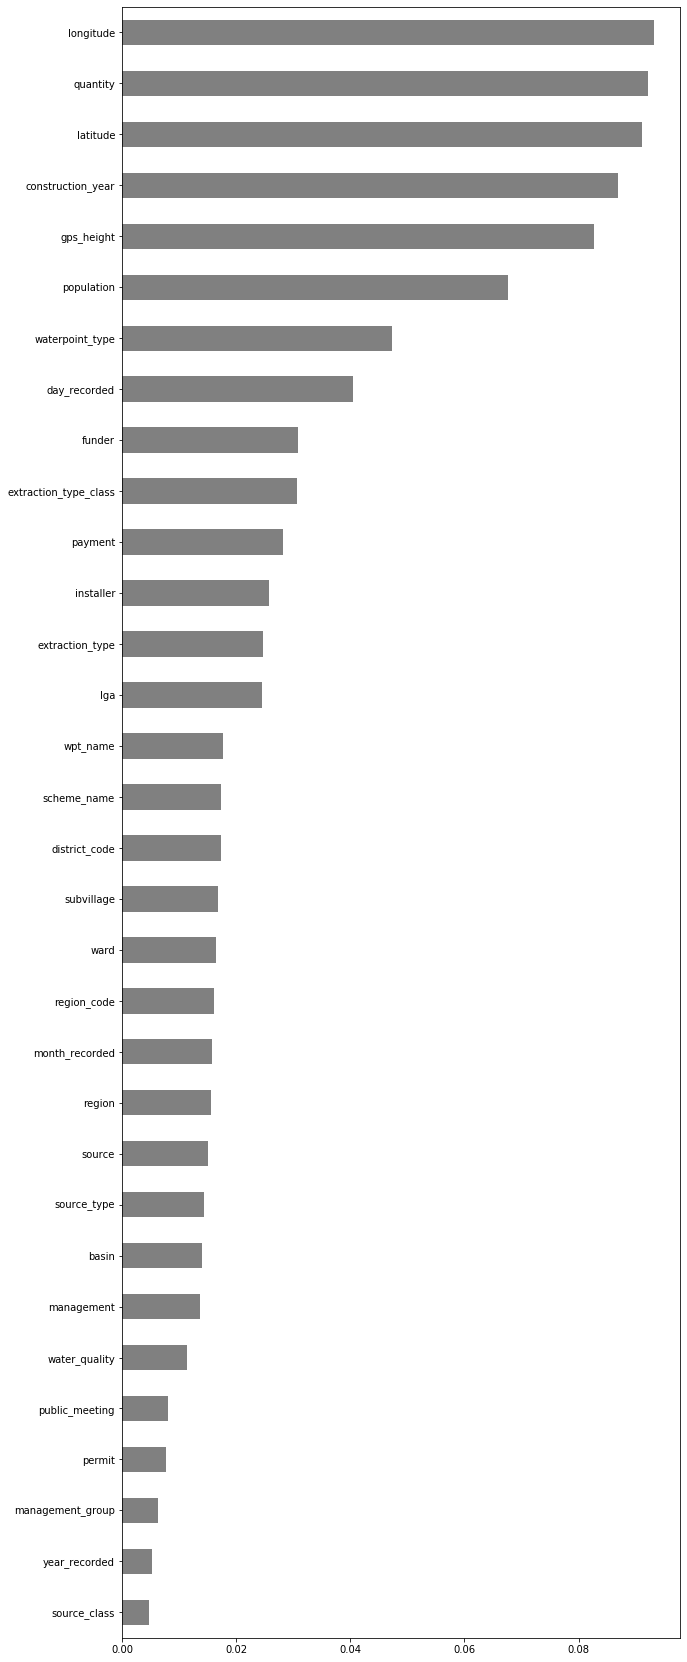

In [1424]:
encoder = rf.named_steps['ordinalencoder']
encoded_columns = encoder.fit_transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');